### Grad-CAM
CAM이라는 Algorithm자체가 CNN을 확인할 수 있는 좋은 방법이기 때문에 좀 더 깊게 알아보자.  
현재 참조한 논문은 <a href="http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf">Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization</a>이고 논문 제목에서도 알 수 있겠지만 이번 Post에서는 많은 CAM방법중에서 Grad-CAM에 초점을 맞춰 알아보고 결과를 확인하여 보자.  

### Abstract  
해당 논문에서 Grad-CAM(Gradient-weighted Class Acrivation Mapping)이란 CNN이라는 Network를 'visual explanation' 하는 방법이라고 나와있습니다.  
먼저 이전 Post의 CNN의 결과를 살펴보면 이해가 빠릅니다.  
먼저 VGG16에서 block1_conv1 Filter를 시각화한 그림입니다.  
<img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Keras/19.png" height="250" width="600"><br>

위의 Filter를 살펴보게 되면 인간이 이해할 수 있습니다.  
대각선 성분을 출력하거나 가로 세로 등의 Image의 큰 Feature를 추출하는 Filter의 집합으로 설명이 가능합니다.  

아래 그림은 block4_conv1 Filter를 시각화한 그림입니다.  
<img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/Keras/20.png" height="250" width="600"><br>
사람이 이해할 수없는 형태로 Filter가 구성되고 특정한 Pattern을 찾고자 하는 것을 발견할 수 있습니다.  

**CNN의 단점은 여기서 발생하게 됩니다. 복잡한 Filter를 인간이 구성할 수 없으므로 Training을 시켜 Model을 만들게 되는데 이러한 Filter가 진짜로 결과에 영향을 미치는지 확인할 수 없다는 점**입니다.  
이러한 단점을 해당논문에서는 Grad-CAM을 이용하여 visual explanation이 가능하다고 하였습니다.  

해당 논문에서는 어떻게 visual explanation하는지 대략적으로 이렇게 나와있습니다.  
>Our approach – Gradient-weighted Class Activation
Mapping (Grad-CAM), uses the gradients of any target concept (say logits for ‘dog’ or even a caption), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept

즉, 예측 이미지안에 중요한 localization map을생산하기 위한 마지막 Convolution Layer로 가는 Target에 대한 Gradient를 사용한다고 나와있습니다.  

따라서 기존 CAM들의 방식과 달리 다양한 범위에서 사용할 수 있다고 나와있습니다.  
(1) CNNs with fully-connected layers (e.g. VGG)  
(2) CNNs used for structured outputs (e.g. captioning)  
(3) CNNs used in tasks with multi-modal inputs (e.g. visual question answering) or reinforcement learning, without architectural changes or re-training  

위의 3가지를 종합해보면 Input에 상관없고 Structured output구조나 FC Layer를 포함한 Model에서도 사용가능하다고 나와있습니다.  

또한 해당 논문에서는 Grad-CAM을 사용함으로써 이점 4가지에 대해서 설명하고 있습니다.  
(a) lend insights into failure modes of these models (showing that seemingly unreasonable predictions have reasonable explanations) -> Model이 왜 결과를 실패했는지 알아낼 수 있습니다.  
(b) outperform previous methods on the ILSVRC-15 weakly-supervised localization task -> 기존 Model보다 Localization을 잘 해낸다.   
(c) are more faithful to the underlying model -> 기존 Model을 그냥 사용하는 것이 아니라 신뢰할 수 있습니다.  
(d) help achieve model generalization by identifying dataset bias -> Dataset의 bias를 확인하여 Model을 Generalization하는데 도움을 줄 수 있다.  

위의 4가지 장점 중에서 이번 Post에서 중점적으로 다룰 것은 (c) 로서 기존 Model의 Visual explanation함으로써 왜 사용하는지에 대해서 알아보도록 하자.  
<br><br>

### Approach
<img src="https://k.kakaocdn.net/dn/dJOBTV/btqxjAQO9gn/JSYq2TvkUgtrkJpTuxOgWK/img.png" srcset="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&amp;fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FdJOBTV%2FbtqxjAQO9gn%2FJSYq2TvkUgtrkJpTuxOgWK%2Fimg.png"><br>
사진 출처: <a href="https://wordbe.tistory.com/entry/Grad-CAMGradient-weighted-Class-Activation-Mapping">wordbe 블로그</a><br>
위의 그림은 논문에서 어떻게 Grad-CAM으로 접근하였는지에 대한 내용이다.  
이제 하나하나 수식을 살펴보자.(현재 이전 Post나 확인하고 하는 Model은 VGG16이며 Classification을 하는 Model로서 접근하고 있습니다.)  

**1. 먼저 Classification을 하기 위하여 Input Image에 대한 마지막 Convolution Layer에서 가장 큰 응답을 하는 FC Layer를 찾아야 한다.**  
최종적으로 적용하고자하는 VGG16을 예시로 생각하면 VGG16의 마지막 Layer는  
```code
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================

...

predictions (Dense)          (None, 1000)              4097000   
=================================================================
Total params: 138,357,544
Trainable params: 138,357,544
Non-trainable params: 0
_________________________________________________________________
```
<br>
로서 들어오는 Image에 대하여 1 x 1000 크기의 Vector를 Input으로 넣어서 Softmax값을 출력한다.  

하나하나의 **Vecotr의 요소는 어떤 Class에 속할 것인지에 대한 확률 값을 Softmax에 넣은 값**으로서 가장 큰 값은 그 Class로 판단한 가장 큰 이유가 된다.  
아래 예시를 살펴보자.  

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras import layers
from keras import models
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K
import cv2

model = VGG16(weights='imagenet')

img_path = './Dataset/creative_commons_elephant.jpg'
img = image.load_img(img_path,target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print(preds.shape)
print('Predicted:',decode_predictions(preds,top=3)[0])
print(np.argmax(preds[0]))

(1, 1000)
Predicted: [('n02504458', 'African_elephant', 0.9101746), ('n01871265', 'tusker', 0.085445076), ('n02504013', 'Indian_elephant', 0.0043368633)]
386


위의 결과를 살펴보게되면 1000개의 Class로 분류하는데 African_elephant일 확률을 90%로 측정하였으며, Index는 386인 것을 확인할 수 있다.  
이러한 결과 값을 확인하였을 때 **CNN의 문제인 왜 이렇게 판단하였는지에 대한 Visual explanation을 하기 위하여 Grad-CAM의 과정을 살펴보자**  

**2. Backpropagation을 통한 Gradient 출력**  
<p>$$a_k^c = \frac{1}{Z}\sum_i \sum_j \frac{\partial y^c}{\partial A_{ij}^k}$$</p>

- c: Class
- <span>$a_k^c$</span>: Grad-CAM의 중요도를 결정하는 Scalar(논문에서는 GAP(Global Average Pooling)이라고 표현하였습니다.)
- <span>$y^c$</span>: Score Class(before the softmax)
- <span>$A_{ij}^k$</span>: Feature maps of aconvolutional Layer

위의 식을 조금 더 생각하면 어떤 Class로 판별해서 출력하는지에 대한 Score Class를 시각화 하고자하는 Convolution Layer로 미분을 통하여 k번째 Feature맵에 대한 Gradient를 얻게 된다.  

생각을 해보면 해당되는 Class가 맞다면 최종적인 출력값을 크게 나올거고 그러한 판단을 한 요소의 값은 크게 나올 수 밖에 없다.  

이러한 값을 Crad-CAM에서는 사용하기 위하여 <span>$a_k^c$</span>라는 수식과 GAP이라는 용어로 어느 Class와 어느 Feature맵에 대한 값으로서 나타내었다.  

**3. Heatmap 생성**  
위에서 GAP이라는 Scalar를 통하여 간단한 수식으로서 최종적인 Heatmap을 구현하였다.  
<p>$$L_{Grad-Cam}^c = ReLU(\sum_k a_k^c A^k)$$</p>

위에서 구한 GAP과 위에서의 Feature Map을 곱함으로써 얻을 수 있다. 클래스의 Interest에서 양의 값의 영향에 관심이 있기 때문에 ReLU를 붙였다.  

조금 더 자세히 설명하면 어떤 Feature Map의 영역의 gradient가 -라면 해당 클래스의 확률을 낮추는 방향으로, 즉 관련 없는 영역일 것이고, 그 반대로+라면 해당 클래스의 확률을 높여줄 것이다. 위에서 가장 큰 Score Class를 뽑아내는 것은 이러한 확률을 가장 높이는 방향으로 결과를 확인하기 위해서 이다.  

위의 정보를 바탕으로 이전 Post에서 Code를 어떻게 작성하였는지 확인해보자.  
<table>
    <tr>
        <td>수식</td>
        <td>Code</td>
        <td>설명</td>
    </tr>
    <tr>
        <td><span>$c$</span></td>
        <td><code>np.argmax(preds[0]) = 386</code></td>
        <td>Model에 Input을 넣어 어떤 Class인지 판별하였고 그 Class가 Softmax Vector에서 몇번째인지 알아내었다.</td>
    </tr>
    <tr>
        <td><span>$y^c$</span></td>
        <td><code>model.output[:,386]</code></td>
        <td>Score Class를 위에서 구한 c를 통하여 대입(Softmax에 들어가기 전의 1 x 1000의 크기의 Vector중에서 African Elephant의 값)</td>
    </tr>
    <tr>
        <td><span>$k$</span></td>
        <td><code>block5_conv3</code></td>
        <td>Visual Explanation하고 싶은 Feature Layer</td>
    </tr>
    <tr>
        <td><span>$A_{ij}^k$</span></td>
        <td><code>model.get_layer('block5_conv3')</code></td>
        <td>구하고자하는 Featuremap</td>
    </tr>
    <tr>
        <td><span>$\frac{\partial y^c}{\partial A_{ij}^k}$</span></td>
        <td><code>K.gradients(african_elephant_output,last_conv_layer.output)[0]</code></td>
        <td>어떤 Class로 판별해서 출력하는지에 대한 Score Class를 시각화 하고자하는 Convolution Layer로 미분을 통하여 k번째 Feature맵에 대한 Gradient를 얻게 된다.</td>
    </tr>
    <tr>
        <td><span>$a_k^c = \frac{1}{Z}\sum_i \sum_j \frac{\partial y^c}{\partial A_{ij}^k}$</span></td>
        <td><code>K.mean(grads,axis=(0,1,2))</code></td>
        <td><b>Input Image에 도달하는 최종적인 Gradient는 RGB값으로 3개의 Channel의 값으로서 들어오게된다. 또한 각각의 평균을 구하는 과정을 추가한다.</b></td>
    </tr>
    <tr>
        <td><span>$\sum_k a_k^c A^k$</span></td>
        <td><code>
            for i in range(512):
                conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
            </code>
        </td>
        <td>Model에서 구하고자 하는 block5_conv3 의 output은 (None, 14, 14, 512)이다 따라서 k=512로 두고 식에 대입한다.</td>
    </tr>
    <tr>
        <td><span>$ReLU(\sum_k a_k^c A^k)$</span></td>
        <td><code>heatmap = np.maximum(heatmap,0)</code></td>
        <td>Interest에서 양의 값의 영향에 관심을 받기위하여 ReLU를 적용</td>
    </tr>
</table>
<br>

위의 과정에서 제외된 <code>heatmap = np.mean(conv_layer_output_value,axis=-1), heatmap /= np.max(heatmap)</code>는 값을 정규화 시켜주는 과정이다.

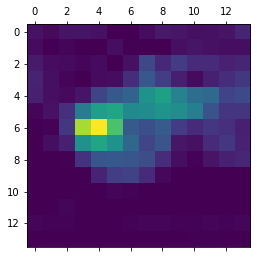

In [48]:
african_elephant_output = model.output[:,386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output,last_conv_layer.output)[0]
pooled_grads = K.mean(grads,axis=(0,1,2))
iterate = K.function([model.input],[pooled_grads,last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value,axis=-1)

heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

**결과 확인**  
아래 그림을 이전 Post보다 HeatMap에 가중치를 조금 더 주어서 결과를 확인하였다.  
**Image를 African_elephant라고 판단한 것은 왼쪽의 아기코끼리의 영향이 크고 또한 이러한 판단의 기준은 코끼리의 코가 중요한 역할을 한다고 말할 수 있다.(오른쪽 코끼리는 거의 코를 중심으로 Feature가 솟구치는 것을 확인할 수 있다.)**

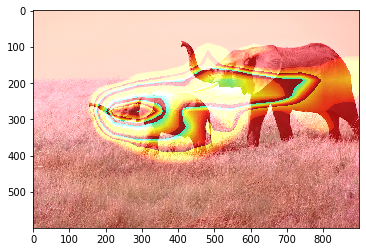

In [51]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1],img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.8 + img

superimposed_img[superimposed_img > 255] = 255
superimposed_img = superimposed_img.astype('uint8')


plt.imshow(superimposed_img)